# 311: Case Volume and Submission Channel Source Analysis

Prepared by Rishi Shah

The purpose of this notebook it to generate high level analysis of the data and answer some key questions given by the stakeholders.
The question this notebook seeks to answer is:
<B>How is the case volume changing by submission channel SOURCE?</B>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as stats

### Prepare and Clean Data

1. download our data with our download script
2. load this data into data frames

In [4]:
# List of file names
file_names = ['../../data/2011.csv', '../../data/2012.csv', '../../data/2013.csv', '../../data/2014.csv', '../../data/2015.csv', 
              '../../data/2016.csv', '../../data/2017.csv', '../../data/2018.csv', '../../data/2019.csv', '../../data/2020.csv',
              '../../data/2021.csv', '../../data/2022.csv', '../../data/2023.csv']

# Read the data from the CSV files into a list of DataFrames to be combined and filter the first row of all of the files except the first one
data_list = []

for file in file_names:
    data = pd.read_csv(file,low_memory=False)
    data_list.append(data)

# Concatenate the DataFrames
df = pd.concat(data_list, ignore_index=True)
df = df[['case_enquiry_id', 'open_dt', 'closed_dt', 'source']]
df.head()

,case_enquiry_id,open_dt,closed_dt,source
0,101000295613,2011-06-30 21:32:33,2011-07-01 01:06:58,Employee Generated
1,101000295614,2011-06-30 22:18:31,2011-07-01 02:12:43,Self Service
2,101000295615,2011-06-30 22:28:04,2011-08-01 11:21:46,Self Service
3,101000295616,2011-06-30 23:03:48,2011-07-22 12:13:45,Self Service
4,101000295617,2011-06-30 23:12:31,2011-07-01 02:12:38,Constituent Call


Extracting Year Progress: 100%|██| 2735254/2735254 [00:00<00:00, 3282396.21it/s]


Grouping Data...


Extracting Year Progress: 100%|████████████████| 86/86 [00:00<00:00, 423.24it/s]


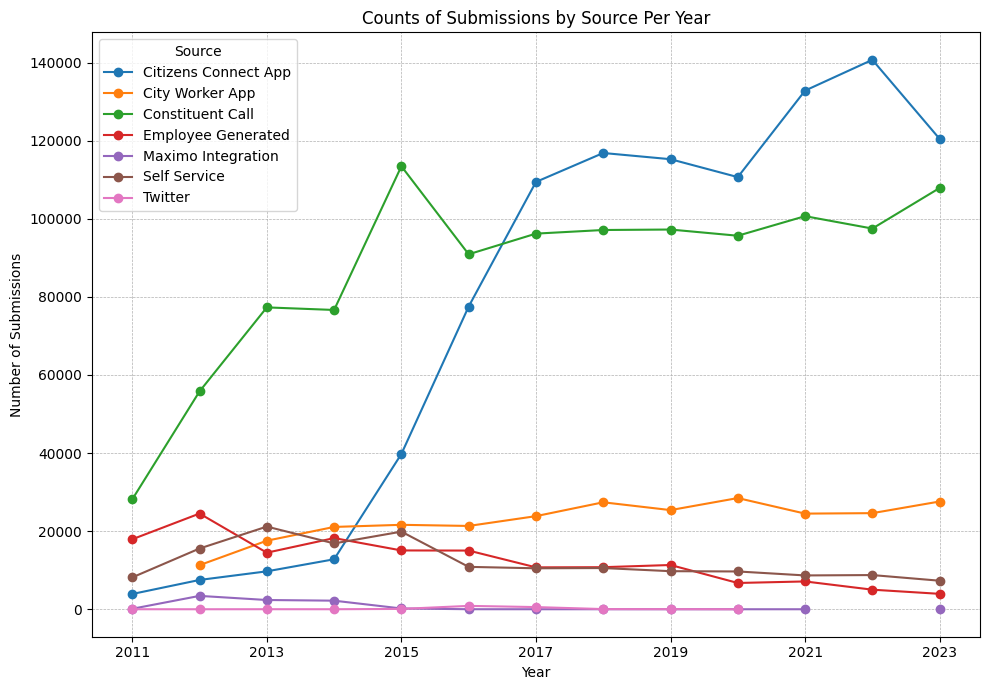

In [5]:
tqdm.pandas(desc="Extracting Year Progress")
df['year'] = df['open_dt'].astype(str).progress_apply(lambda x: x[:4])

# Wrap the groupby operation with tqdm to get a progress bar
print("Grouping Data...")
grouped_series = df.groupby(['year', 'source']).progress_apply(len)
grouped = grouped_series.unstack()

# Plotting
grouped.plot(kind='line', figsize=(10,7), marker='o')
plt.title("Counts of Submissions by Source Per Year")
plt.ylabel("Number of Submissions")
plt.xlabel("Year")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(title="Source")
plt.show()

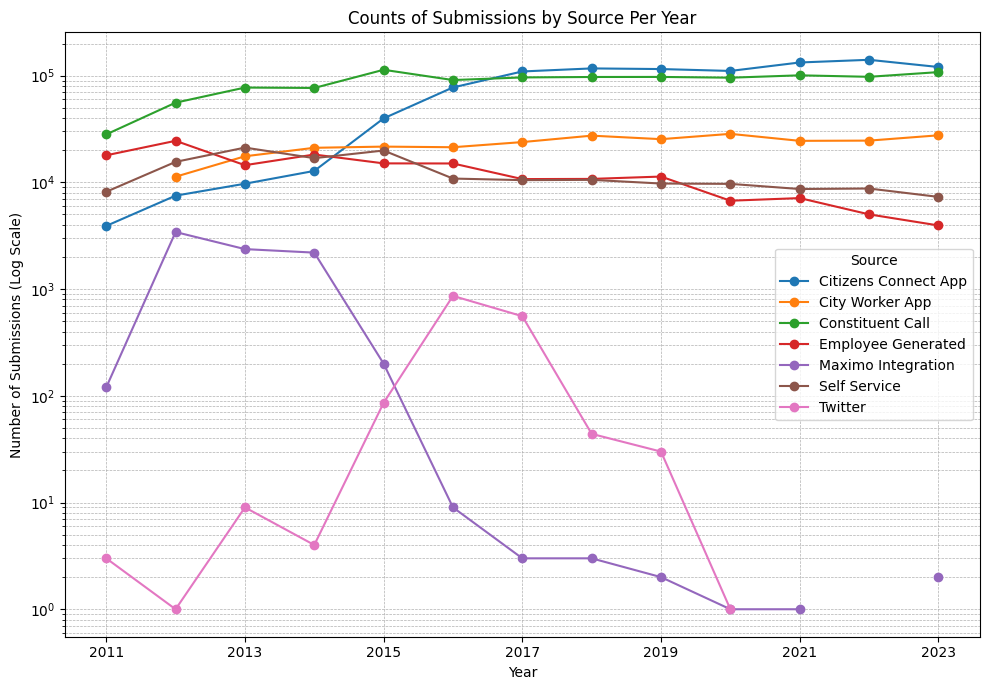

In [6]:
ax = grouped.plot(kind='line', figsize=(10,7), marker='o')
ax.set_yscale('log')
plt.title("Counts of Submissions by Source Per Year")
plt.ylabel("Number of Submissions (Log Scale)")
plt.xlabel("Year")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(title="Source")
plt.show()

From our initial view, it is apparent that the Citizens Connect App has the biggest growth in raw submission count. We need to look at the other features on a logscale to see their patterns more clearly.


This gives some interesting insight, submissions by twitter and maximo integration hve decreased on net, with a sizable increase in twitter submissions between 2014 and 2016


This gives some interesting insight, submissions by twitter and maximo integration hve decreased on net, with a sizable increase in twitter submissions between 2014 and 2016

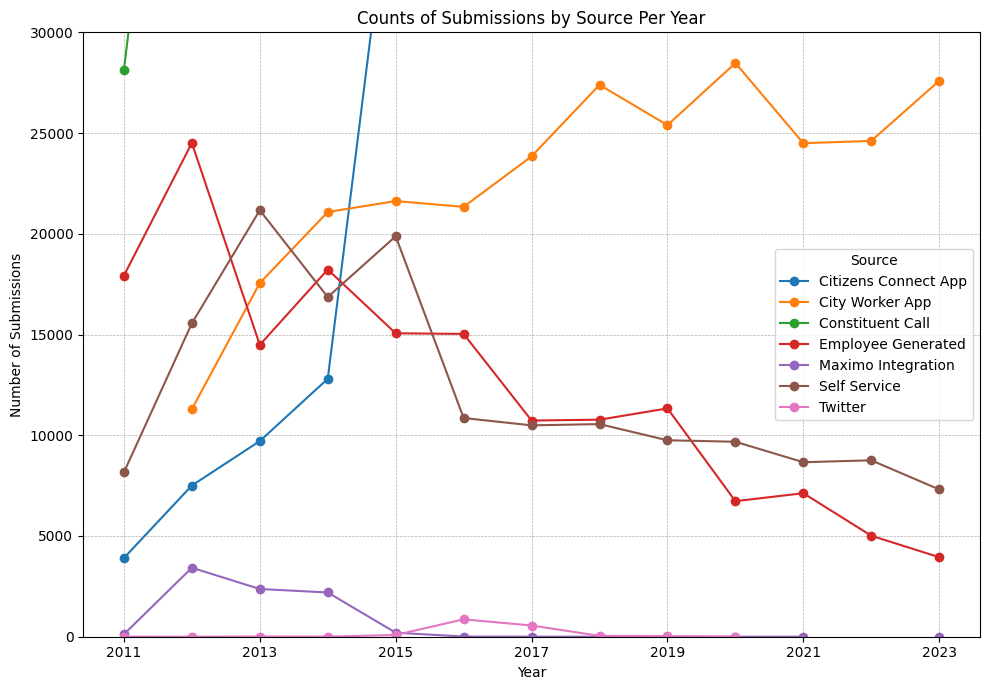

In [7]:
# Plotting
ax = grouped.plot(kind='line', figsize=(10,7), marker='o')
ax.set_ylim(0, 30000)  # Setting the y-axis limit here
plt.title("Counts of Submissions by Source Per Year")
plt.ylabel("Number of Submissions")
plt.xlabel("Year")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(title="Source")
plt.show()

## Hypothesis 1: app-based submission courses are generating more submissions than traditional channels

Let's explore this hypothesis with a two sample t-test

In [8]:
source_counts = df.groupby('source').size()

# Classify sources as app-based or traditional
app_based = ['Citizens Connect App', 'City Worker App']
traditional = [source for source in source_counts.index if source not in app_based]

# Extract counts for both groups
app_counts = source_counts[app_based].values
trad_counts = source_counts[traditional].values

# Check assumptions: Homogeneity of variances
_, p_value_var = stats.levene(app_counts, trad_counts)
if p_value_var < 0.05:
    equal_var = False
else:
    equal_var = True

# Perform t-test
t_stat, p_value = stats.ttest_ind(app_counts, trad_counts, equal_var=equal_var)

print(f"T-statistic: {t_stat}\nP-value: {p_value}")

T-statistic: 0.8482309992596883
P-value: 0.4350253230669681


Given the p-value of 0.4350, I fail to reject the null hypothesis. This means that, based on the data you've provided and at the usual 0.05 significance level, there isn't enough evidence to conclude that there's a statistically significant difference between the means of app-based and traditional submission counts.